<a href="https://colab.research.google.com/github/shubo7996/Comp_Neuro_NMA/blob/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Confidence intervals and bootstrapping

**Week 1, Day 2: Model Fitting**

**By Neuromatch Academy**

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil with help from Byron Galbraith

**Content reviewers**: Lina Teichmann, Saeed Salehi, Patrick Mineault, Ella Batty, Michael Waskom

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

# Tutorial Objectives

*Estimated timing of tutorial: 23 minutes*

This is Tutorial 3 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression (Tutorial 4). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).

In this tutorial, we will discuss how to gauge how good our estimated model parameters are. 
- Learn how to use bootstrapping to generate new sample datasets
- Estimate our model parameter on these new sample datasets
- Quantify the variance of our estimate using confidence intervals

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/2mkq4/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

In [2]:
# @title Video 1: Confidence Intervals & Bootstrapping
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1vK4y1s7py", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="hs6bVGQNSIs", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Up to this point we have been finding ways to estimate model parameters to fit some observed data. Our approach has been to optimize some criterion, either minimize the mean squared error or maximize the likelihood while using the entire dataset. How good is our estimate really? How confident are we that it will generalize to describe new data we haven't seen yet?

One solution to this is to just collect more data and check the MSE on this new dataset with the previously estimated parameters. However this is not always feasible and still leaves open the question of how quantifiably confident we are in the accuracy of our model.

In Section 1, we will explore how to implement bootstrapping. In Section 2, we will build confidence intervals of our estimates using the bootstrapping method.

---
# Setup

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting Functions

def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim());

---
# Section 1: Bootstrapping

*Estimated timing to here from start of tutorial: 7 min*

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a widely applicable method to assess confidence/uncertainty about estimated parameters, it was originally [proposed](https://projecteuclid.org/euclid.aos/1176344552) by [Bradley Efron](https://en.wikipedia.org/wiki/Bradley_Efron). The idea is to generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding estimators for each one of these new datasets, and finally looking at the distribution of all these estimators to quantify our confidence.

Note that each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times. Also note that in practice we need a lot of resampled datasets, here we use 2000.

To explore this idea, we will start again with our noisy samples along the line $y_i = 1.2x_i + \epsilon_i$, but this time, we only use half the data points as last time (15 instead of 30).

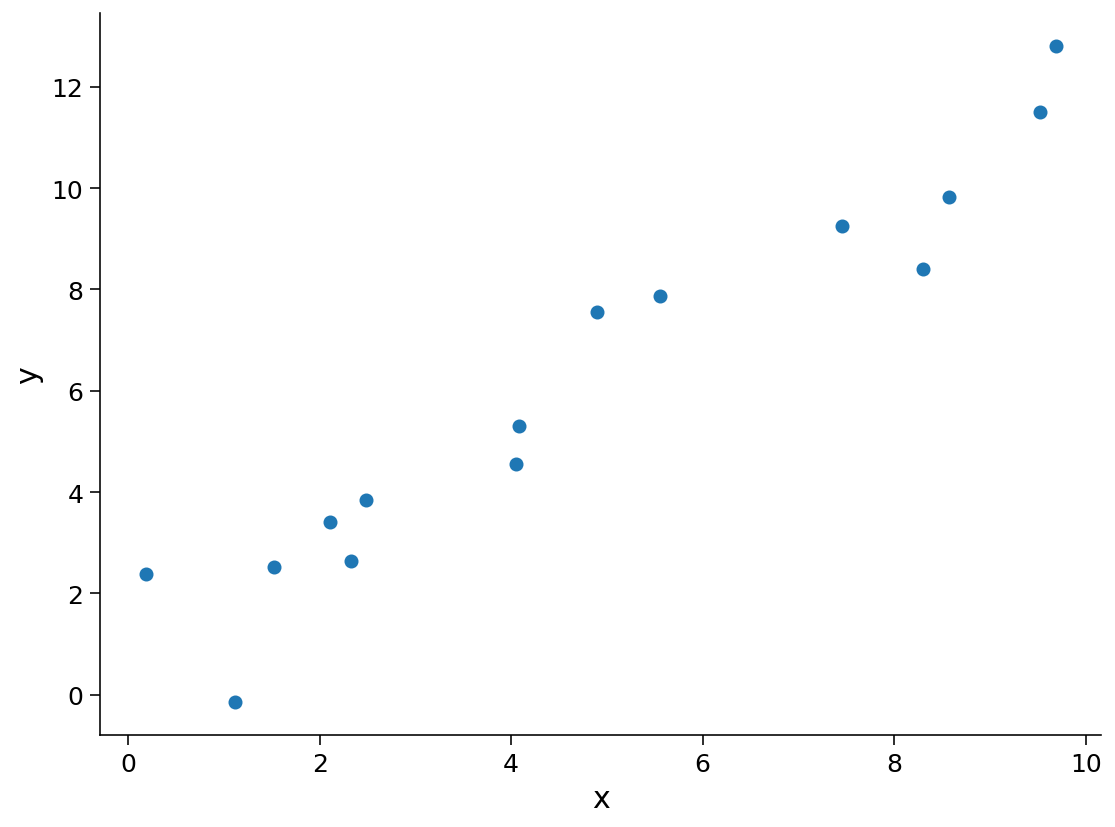

In [6]:
#@title

#@markdown Execute this cell to simulate some data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 15

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

## Coding Exercise 1: Resample Dataset with Replacement

In this exercise you will implement a method to resample a dataset with replacement. The method accepts $\mathbf{x}$ and $\mathbf{y}$ arrays. It should return a new set of $\mathbf{x}'$ and $\mathbf{y}'$ arrays that are created by randomly sampling from the originals.

We will then compare the original dataset to a resampled dataset.

**Hint:** The [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) method would be useful here.

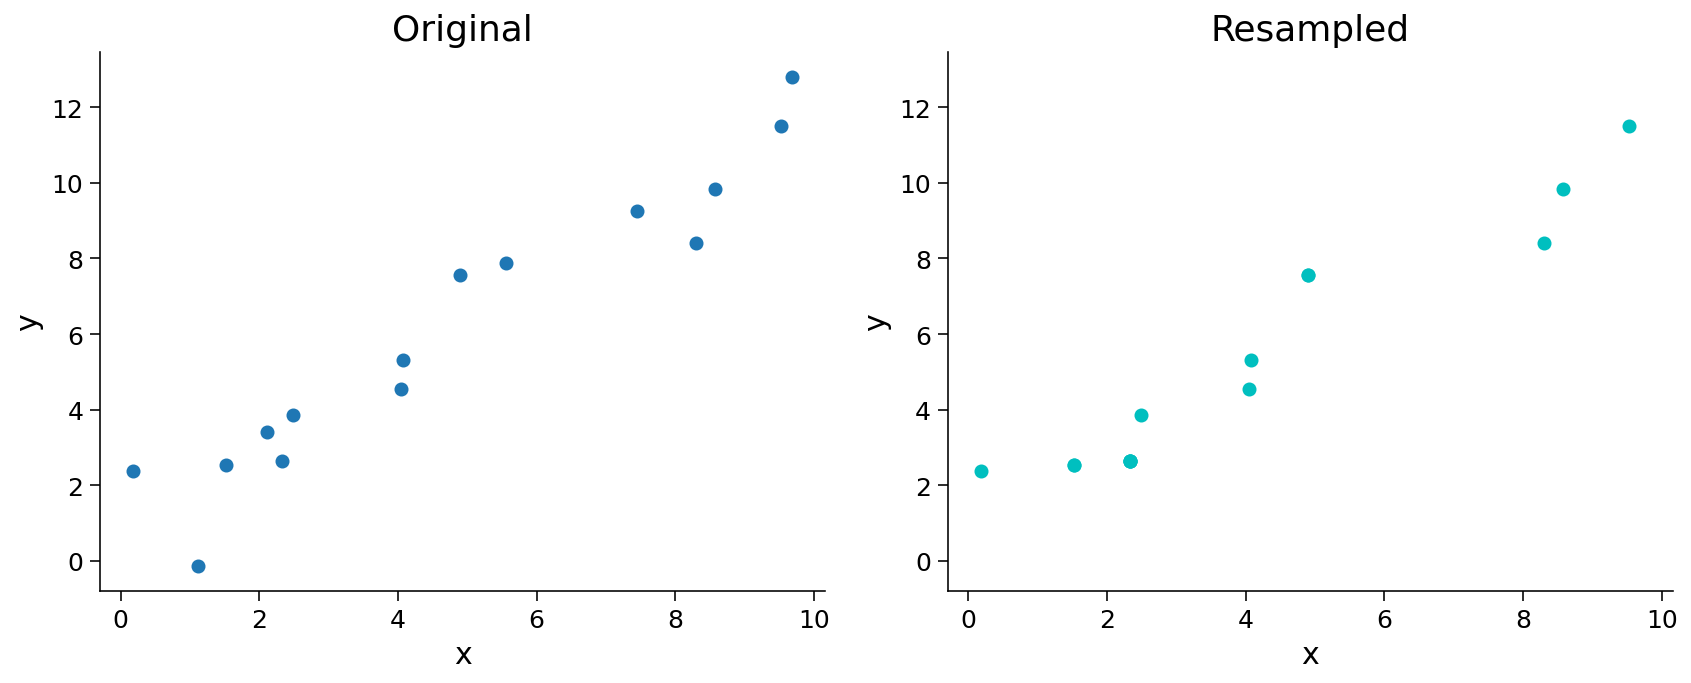

In [10]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """
  #######################################################
  ## TODO for students: resample dataset with replacement
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: resample dataset with replacement")
  #######################################################
  #23 --> 0 to 23 --> 5,5,5,5,6,6,19,,12.....23 outputs
  # Get array of indices for resampled points
  sample_idx = np.random.choice(len(x),len(x))

  # Sample from x and y according to sample_idx
  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

x_, y_ = resample_with_replacement(x, y)

plot_original_and_resample(x, y, x_, y_)

In [13]:
x_

array([8.57606117, 2.32962488, 2.48499756, 4.0493829 , 2.32962488,
       0.18297309, 8.30178138, 4.8984885 , 2.32962488, 1.51944557,
       2.32962488, 1.51944557, 9.52684176, 4.07919415, 4.8984885 ])

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial3_Solution_81af3bd6.py)

*Example output:*

<img alt='Solution hint' align='left' width=1711.0 height=705.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D2_ModelFitting/static/W1D2_Tutorial3_Solution_81af3bd6_0.png>



In the resampled plot on the right, the actual number of points is the same, but some have been repeated so they only display once.

Now that we have a way to resample the data, we can use that in the full bootstrapping process.

## Coding Exercise 2: Bootstrap Estimates

In this exercise you will implement a method to run the bootstrap process of generating a set of $\hat\theta$ values from a dataset of inputs ($\mathbf{x}$) and  measurements ($\mathbf{y}$). You should use `resample_with_replacement` here, and you may also invoke the helper function `solve_normal_eqn` from Tutorial 1 to produce the MSE-based estimator.

We will then use this function to look at the theta_hat from different samples.


In [11]:
# @markdown Execute this cell for helper function `solve_normal_eqn`
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    thata_hat (float): An estimate of the slope parameter.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """
  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat

In [16]:
def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute

  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  ##############################################################################
  ## TODO for students: implement bootstrap estimation
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: implement bootstrap estimation")
  ##############################################################################

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y) #x_ --> is an array y_ is also an array

    # Compute theta_hat for this sample
    theta_hats[i] = solve_normal_eqn(x_,y_)

  return theta_hats


# Set random seed
np.random.seed(123)

# Get bootstrap estimates
theta_hats = bootstrap_estimates(x, y, n=2000)
print(theta_hats[0:5])

[1.27550888 1.17317819 1.18198819 1.25329255 1.20714664]


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial3_Solution_d73b40e4.py)



You should see `[1.27550888 1.17317819 1.18198819 1.25329255 1.20714664]` as the first five estimates.

Now that we have our bootstrap estimates, we can visualize all the potential models (models computed with different resampling) together to see how distributed they are.

In [ ]:
#@title
#@markdown Execute this cell to visualize all potential models

fig, ax = plt.subplots()

# For each theta_hat, plot model
theta_hats = bootstrap_estimates(x, y, n=2000)
for i, theta_hat in enumerate(theta_hats):
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

# Plot observed data
ax.scatter(x, y, label='Observed')

# Plot true fit data
y_true = theta * x
ax.plot(x, y_true, 'g', linewidth=2, label='True Model')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)

# Change legend line alpha property
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend();

This looks pretty good! The bootstrapped estimates spread around the true model, as we would have hoped. Note that here we have the luxury to know the ground truth value for $\theta$, but in applications we are trying to guess it from data. Therefore, assessing  the  quality  of  estimates  based  on  finite data is a task of fundamental importance in data analysis.


---
# Section 2: Confidence Intervals

*Estimated timing to here from start of tutorial: 17 min*

Let us now quantify how uncertain our estimated slope is. We do so by computing [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) (CIs) from our bootstrapped estimates. The most direct approach is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.

mean = 1.24, std = 0.05


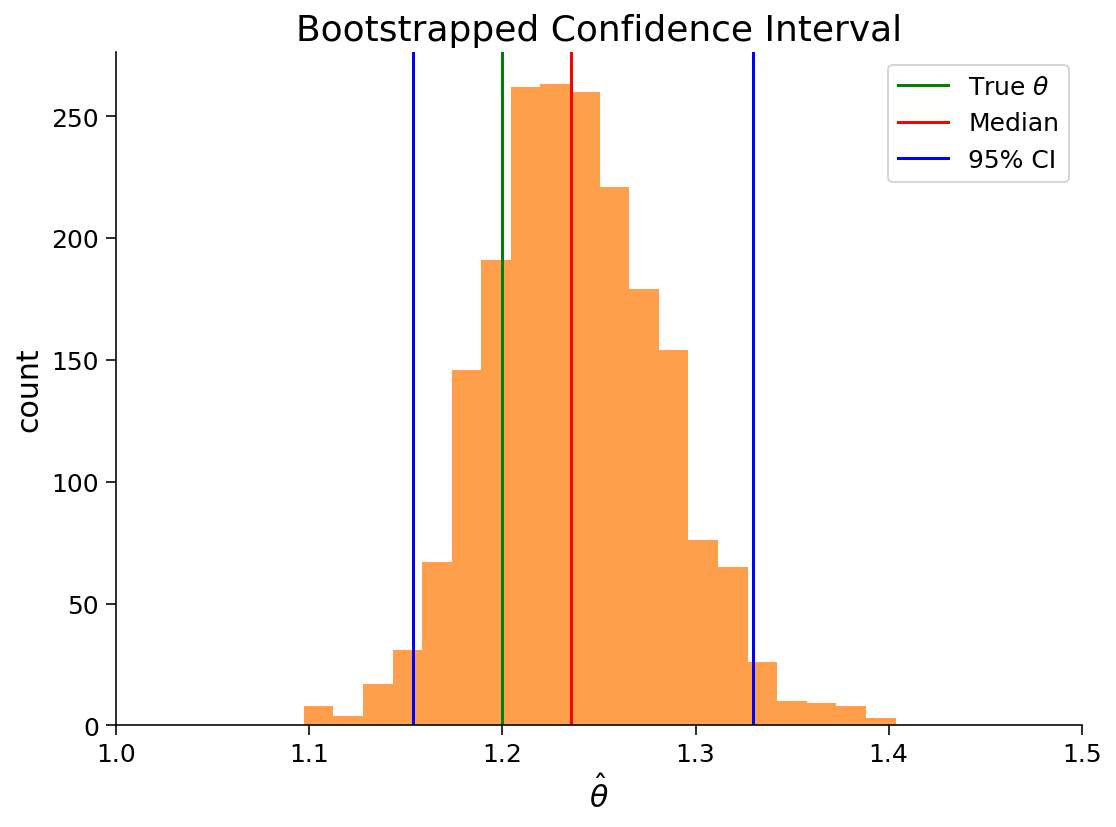

In [17]:
#@title

#@markdown Execute this cell to plot bootstrapped CI

theta_hats = bootstrap_estimates(x, y, n=2000)
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, bins=20, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='g', label=r'True $\theta$')
ax.axvline(np.percentile(theta_hats, 50), color='r', label='Median')
ax.axvline(np.percentile(theta_hats, 2.5), color='b', label='95% CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='b')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{{\theta}}$',
    ylabel='count',
    xlim=[1.0, 1.5]
);

Looking at the distribution of bootstrapped $\hat{\theta}$ values, we see that the true $\theta$ falls well within the 95% confidence interval, which is reassuring. We also see that the value $\theta = 1$ does not fall within the confidence interval. From this we would reject the hypothesis that the slope was 1.

---
# Summary

*Estimated timing of tutorial: 23 minutes*

- Bootstrapping is a resampling procedure that allows to build confidence intervals around inferred parameter values
- it is a widely applicable and very practical method that relies on computational power and pseudo-random number generators (as opposed to more classical approaches than depend on analytical derivations)

---
# Notation

\begin{align}
\theta &\quad \text{parameter}\\
\hat{\theta} &\quad \text{estimated parameter}\\
x &\quad \text{input, independent variable}\\
y &\quad \text{response measurement, dependent variable}\\
\mathbf{x} &\quad \text{vector of input values}\\
\mathbf{y} &\quad \text{vector of measurements}\\
\mathbf{x}' &\quad \text{vector of resampled input values }\\
\mathbf{y}' &\quad \text{vector of resampled measurement values}\\
\end{align}

**Suggested readings**  

Computer Age Statistical Inference: Algorithms, Evidence and Data Science, by Bradley Efron and Trevor Hastie
